In [72]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM, GRU, TimeDistributed
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, MaxPool2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd
import random
import import_ipynb
import Sample_making
from models.cnn import CNN_model

In [2]:
df_target = pd.read_csv('../../Target_words_dataframe')
df_unknown = pd.read_csv('../../Unknown_words_dataframe')
df = pd.read_csv('../../full_df')

In [3]:
df_target = df_target.drop(columns=['Unnamed: 0'], axis=1)
df_unknown = df_unknown.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
def get_mfcc(path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=1, sr=44100, offset=0)
    sample_rate = np.array(sample_rate)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=30)
    if mfccs.shape[1] < 61:
        b = np.zeros((30, 61 - mfccs.shape[1]))
        mfccs = np.concatenate((mfccs, b), axis=1)
    if mfccs.shape[1] > 61:
        mfccs = mfccs[:, :61]
    mfccs = np.expand_dims(mfccs, axis=0)
    return mfccs

In [ ]:
temp = []

for index,path in enumerate(df.path):  
    print(index)
    mfccs = get_mfcc(path)
    temp.append(mfccs)

X = np.concatenate(temp, axis=0)

In [19]:
filename = 'Data_spotter_mfcc'
outfile = open(filename,'wb')
pickle.dump(X,outfile)
outfile.close()

In [6]:
filename = 'Data_spotter_mfcc'
outfile = open(filename,'rb')
X = pickle.load(outfile)
outfile.close()

In [7]:
def save_model(Model, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    Model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    model_json = Model.to_json()
    with open("model_json.json", "w") as json_file:
        json_file.write(model_json)

In [8]:
def save_model_history(model_history, model_history_name):
    filename = 'saved_models_history/' + model_history_name
    outfile = open(filename,'wb')
    pickle.dump(model_history, outfile)
    outfile.close()

In [78]:
def report(model, X, y, classes):
    model_predictions = model.predict(X).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return sklearn.metrics.classification_report(true_predictions, model_predictions, target_names=classes)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , df.word
                                                    , test_size=0.1
                                                    , shuffle=True
                                                    , random_state=42)

In [10]:
Y_train.value_counts() / len(Y_train)

unknown    0.634494
stop       0.036825
go         0.036791
yes        0.036705
on         0.036705
no         0.036619
off        0.036585
up         0.036482
left       0.036345
right      0.036310
down       0.036139
Name: word, dtype: float64

In [11]:
Y_test.value_counts() / len(Y_test)

unknown    0.630465
down       0.039240
right      0.038931
up         0.038622
no         0.037386
yes        0.036923
left       0.036459
stop       0.036305
on         0.035378
go         0.035378
off        0.034914
Name: word, dtype: float64

In [12]:
print(f'X_train size = {X_train.shape}')
print(f'Y_train size = {Y_train.shape}')
print(f'X_test size = {X_test.shape}')
print(f'Y_test size = {Y_test.shape}')

X_train size = (58248, 30, 61)
Y_train size = (58248,)
X_test size = (6473, 30, 61)
Y_test size = (6473,)


In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [14]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [15]:
lb = LabelEncoder()
Y_train = np_utils.to_categorical(lb.fit_transform(Y_train))
Y_test = np_utils.to_categorical(lb.fit_transform(Y_test))
print(lb.classes_)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unknown' 'up' 'yes']


In [16]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(f'X_train size = {X_train.shape}')
print(f'X_test size = {X_test.shape}')

X_train size = (58248, 30, 61, 1)
X_test size = (6473, 30, 61, 1)


In [17]:
model = CNN_model((30, 61, 1), len(lb.classes_))

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 61, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 61, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 61, 64)        61504     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 61, 64)        61504     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 61, 64)        61504     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 61, 128)       82048     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 61, 64)        41024 

In [ ]:
# Обучалось на mfcc (30, 61) лежит в Data_spotter_mfcc

opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ["accuracy"])

model_history = model.fit(x = X_train, y = Y_train, epochs = 3, batch_size = 16, validation_data=(X_test, Y_test))

In [22]:
model_history_1 = model.fit(x = X_train, y = Y_train, epochs = 3, batch_size = 16, validation_data=(X_test, Y_test))

Epoch 1/3
3641/3641 [==============================] - 3153s 866ms/step - loss: 0.0484 - accuracy: 0.9047 - val_loss: 0.0505 - val_accuracy: 0.8953
Epoch 2/3
3641/3641 [==============================] - 2800s 769ms/step - loss: 0.0419 - accuracy: 0.9174 - val_loss: 0.0493 - val_accuracy: 0.9021
Epoch 3/3
3641/3641 [==============================] - 2792s 767ms/step - loss: 0.0372 - accuracy: 0.9264 - val_loss: 0.0457 - val_accuracy: 0.9141


In [41]:
save_model(model, "CNN")

INFO:tensorflow:Assets written to: C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\CNN\assets
Save model and weights at C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\CNN 


In [42]:
save_model_history(model_history.history, "CNN_1")
save_model_history(model_history_1.history, "CNN_2")

In [22]:
# classification report sklearn
# посмотреть на чем обучают в kws_streaming
# убрать оффсет
# добавить аргументаций, дропауты?
# посмотреть как ошибка распределена по классам, (сбалансировать X_test, Y_test)

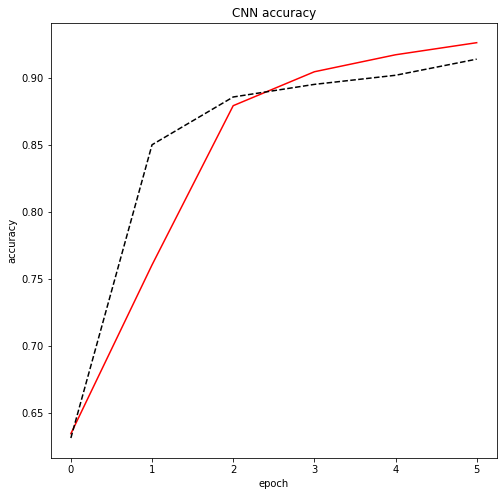

In [25]:
plt.figure(figsize=(8,8))
plt.plot(model_history.history['accuracy'] + model_history_1.history['accuracy'], 
         color="red")
plt.plot(model_history.history['val_accuracy'] + model_history_1.history['val_accuracy'], 
         color="black", 
         linestyle="dashed")
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("CNN_97")
plt.show()

In [79]:
print(report(model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.94      0.73      0.82       254
          go       0.90      0.78      0.84       229
        left       0.93      0.81      0.86       236
          no       0.78      0.87      0.83       242
         off       0.85      0.82      0.83       226
          on       0.94      0.73      0.82       229
       right       0.96      0.78      0.86       252
        stop       0.94      0.90      0.92       235
     unknown       0.92      0.98      0.95      4081
          up       0.82      0.78      0.80       250
         yes       0.96      0.90      0.93       239

    accuracy                           0.91      6473
   macro avg       0.90      0.82      0.86      6473
weighted avg       0.91      0.91      0.91      6473

